In [1]:
import numpy as np
import warnings
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1. Import your custom engine
from data_loader import MarketDataLoader
from quant_math_engine import bates_call_price, implied_volatility

# 2. Load Data (Only reads Parquet once)
BASE_DIR = r"G:\My Drive\00) Interview Prep\00) Quant\Data Sources\WRDS Data\Returns\Options"
loader = MarketDataLoader(BASE_DIR)

TARGET_DATE = '2024-01-10'
TARGET_EXDATE = '2024-02-16'
state = loader.get_market_state(TARGET_DATE, TARGET_EXDATE, strike_bound_pct=0.10)

S0, T, r, q = state['S0'], state['T'], state['r'], state['q']
market_strikes, market_prices = state['strikes'], state['prices']

# 3. Calculate Market IVs
target_ivs, valid_strikes = [], []
for i, K in enumerate(market_strikes):
    iv = implied_volatility(market_prices[i], S0, K, T, r, q)
    if not np.isnan(iv):
        target_ivs.append(iv)
        valid_strikes.append(K)

valid_strikes = np.array(valid_strikes)
target_ivs = np.array(target_ivs)
print(f"✅ Ready! Targeting {len(valid_strikes)} liquid strikes.")

Loading Options, Spot, Yield, and Dividend Data into memory...
✅ Data Loaded Successfully.
✅ Ready! Targeting 352 liquid strikes.


In [2]:
# --- THE SPEED FIX: Downsample the data ---
sample_step = max(1, len(valid_strikes) // 40) 
target_strikes_sampled = valid_strikes[::sample_step]
target_ivs_sampled = target_ivs[::sample_step]

print(f"Downsampled from {len(valid_strikes)} to {len(target_strikes_sampled)} strikes for 10x faster optimization.")

# --- BATES OBJECTIVE FUNCTION ---
def bates_objective(params):
    v0, kappa, theta, xi, rho, lam, mu_j, delta = params
    error = 0.0
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Loop through the SMALL array to save massive amounts of time
        for i, K in enumerate(target_strikes_sampled):
            m_price = bates_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho, lam, mu_j, delta)
            m_iv = implied_volatility(m_price, S0, K, T, r, q)
            
            if np.isnan(m_iv): error += 5.0
            else: error += (m_iv - target_ivs_sampled[i])**2
                
    return error / len(target_strikes_sampled)

# Parameter Seeding: [v0, kappa, theta, xi, rho, lam, mu_j, delta]
# We start with your winning parameters from the Heston and Merton runs!
bates_guess = [0.0115, 3.0293, 0.0684, 1.1963, -0.6572, 0.9923, -0.0825, 0.0779]

bates_bounds = [
    (0.005, 0.15), (0.5, 5.0), (0.005, 0.15), (0.05, 1.5), (-0.95, -0.2), # Heston components
    (0.0, 3.0), (-0.5, 0.0), (0.01, 0.3)                                  # Merton components
]

print("Optimizing Bates Parameters (Seeded Fast Search)...")
start_time = time.time()
res_bates = minimize(bates_objective, bates_guess, method='L-BFGS-B', bounds=bates_bounds)

print(f"✅ Finished in {round(time.time() - start_time, 2)}s")
print(f"Optimal Parameters: {res_bates.x}")
print(f"Mean Squared Error: {res_bates.fun:.6f}")

Downsampled from 352 to 44 strikes for 10x faster optimization.
Optimizing Bates Parameters (Seeded Fast Search)...
✅ Finished in 138.9s
Optimal Parameters: [ 0.005       3.03227026  0.10706195  1.49104011 -0.67036382  1.0118486
  0.          0.0220192 ]
Mean Squared Error: 0.000034


Generating Bates Volatility Smile...


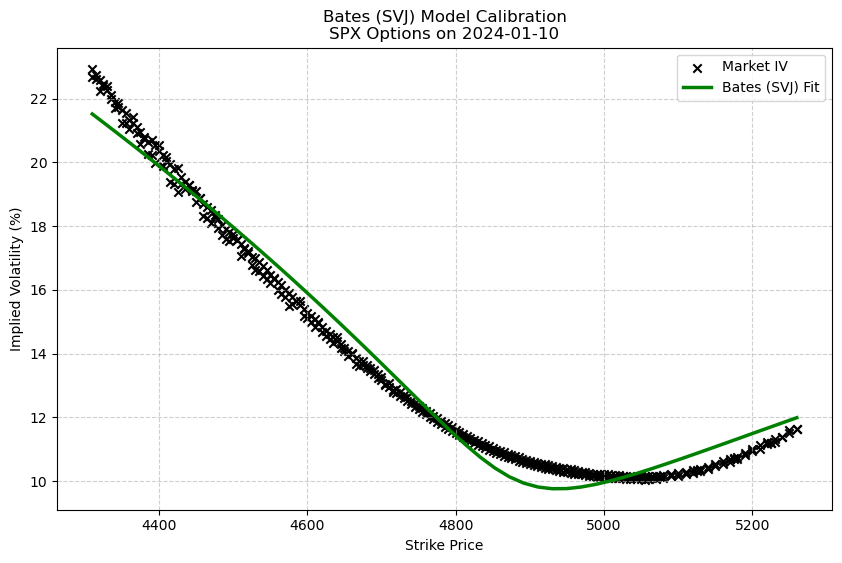


🏆 FINAL BATES PARAMETERS DICTIONARY (Copy this!)
bates_params = {
    'v0': 0.0050,
    'kappa': 3.0323,
    'theta': 0.1071,
    'xi': 1.4910,
    'rho': -0.6704,
    'lam': 1.0118,
    'mu_j': 0.0000,
    'delta': 0.0220
}


In [3]:
print("Generating Bates Volatility Smile...")

smooth_strikes = np.linspace(min(valid_strikes), max(valid_strikes), 50)
bates_prices = [bates_call_price(S0, k, T, r, q, *res_bates.x) for k in smooth_strikes]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bates_iv = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(bates_prices, smooth_strikes)]

valid_idx = ~np.isnan(bates_iv)
clean_strikes = np.array(smooth_strikes)[valid_idx]
clean_iv = np.array(bates_iv)[valid_idx] * 100

plt.figure(figsize=(10, 6))
plt.scatter(valid_strikes, target_ivs * 100, color='black', label='Market IV', marker='x')
plt.plot(clean_strikes, clean_iv, color='green', label='Bates (SVJ) Fit', linewidth=2.5)

plt.title(f"Bates (SVJ) Model Calibration\nSPX Options on {TARGET_DATE}")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ==========================================
# SAVE THE FINAL PARAMETERS FOR NOTEBOOK 09
# ==========================================
print("\n" + "="*50)
print("🏆 FINAL BATES PARAMETERS DICTIONARY (Copy this!)")
print("="*50)
print("bates_params = {")
print(f"    'v0': {res_bates.x[0]:.4f},")
print(f"    'kappa': {res_bates.x[1]:.4f},")
print(f"    'theta': {res_bates.x[2]:.4f},")
print(f"    'xi': {res_bates.x[3]:.4f},")
print(f"    'rho': {res_bates.x[4]:.4f},")
print(f"    'lam': {res_bates.x[5]:.4f},")
print(f"    'mu_j': {res_bates.x[6]:.4f},")
print(f"    'delta': {res_bates.x[7]:.4f}")
print("}")